to check the normalization of the QE is to cross-correlate QE with the true input kappa, and compare that with the power spectrum of the true kappa. The ratio should be unity

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))

#to get latex to work, shoulldn't be necessary for most ppl
os.environ['PATH'] = "%s:/usr/local/cuda-11.2/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/anaconda/bin:/home/delon/texlive/bin/x86_64-linux:/home/delon/.local/bin:/home/delon/bin"%os.environ['PATH']

In [3]:
from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr


In [4]:
print("Map properties")

# number of pixels for the flat map
nX = 800 # 1200
nY = 800 #1200

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra

Map properties


In [5]:
print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# Total power spectrum, for the lens reconstruction
# basiscally gets what we theoretically expect the
# power spectrum will look like
forCtotal = lambda l: cmb.ftotal(l) 

# reinterpolate: gain factor 10 in speed
L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

CMB experiment properties


In [6]:
print("CMB lensing power spectrum")
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)

CMB lensing power spectrum


In [7]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(cmb.funlensedTT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


/code/delon/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: divide by zero encountered in divide
  resultFourier = 1./resultFourier
/code/delon/LensQuEst/LensQuEst/flat_map.py:1668: RuntimeWarning: invalid value encountered in divide
  resultFourier = 1./resultFourier


In [9]:
IN_DATA_FNAME = '/data/delon/LensQuEst/map_sims_800x800_20x20.pkl'
DATA_FNAME = '/data/delon/LensQuEst/QE_and_Nhat_from_map_sims_800x800_20x20.pkl'

f = open(IN_DATA_FNAME, 'rb') 
in_data = pickle.load(f) 
f.close()
for key in in_data:
    print(key, np.shape(in_data[key]))
    
    
f = open(DATA_FNAME, 'rb') 
data = pickle.load(f) 
f.close()
for key in data:
    print(key, np.shape(data[key]))



cmb0F_1 (100, 800, 401)
kCmbF_1 (100, 800, 401)
lCmbF_1 (100, 800, 401)
lCmbF_o1_1 (100, 800, 401)
lCmbF_o2_1 (100, 800, 401)
lCmbF_o3_1 (100, 800, 401)
lCmbF_o4_1 (100, 800, 401)
fgF_1 (100, 800, 401)
noiseF_1 (100, 800, 401)
totalF_1 (100, 800, 401)
totalF_0 (100, 800, 401)
00 (100, 800, 401)
00_sqrtN (100, 800, 401)
01 (100, 800, 401)
01_sqrtN (0,)
10 (100, 800, 401)
10_sqrtN (0,)
11 (100, 800, 401)
11_sqrtN (100, 800, 401)
02 (100, 800, 401)
02_sqrtN (0,)
20 (100, 800, 401)
20_sqrtN (0,)
-1-1 (100, 800, 401)
-1-1_sqrtN (100, 800, 401)
-2-2 (100, 800, 401)
-2-2_sqrtN (100, 800, 401)


In [32]:
from tqdm import trange
ck = 'kkT'

ps_data = {}
for i in trange(100):
    kCmbFourier = in_data['kCmbF_1'][i]

    Cls = {}
    kap  = data['-1-1'][i]
    Cls['kkT'] = [0,0,0]
    Cls['kkT'][0],Cls['kkT'][1],Cls['kkT'][2] = baseMap.crossPowerSpectrum(kap, kCmbFourier)
        
    if(ck not in ps_data.keys()):
        ps_data[ck] = np.array([Cls[ck]])
    else:
        ps_data[ck] = np.vstack((np.array([Cls[ck]]), ps_data[ck]))  

100%|██████████| 100/100 [00:03<00:00, 31.93it/s]


In [33]:
def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
    sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    return lCen, Cls, sCls

100 (100, 3, 50)


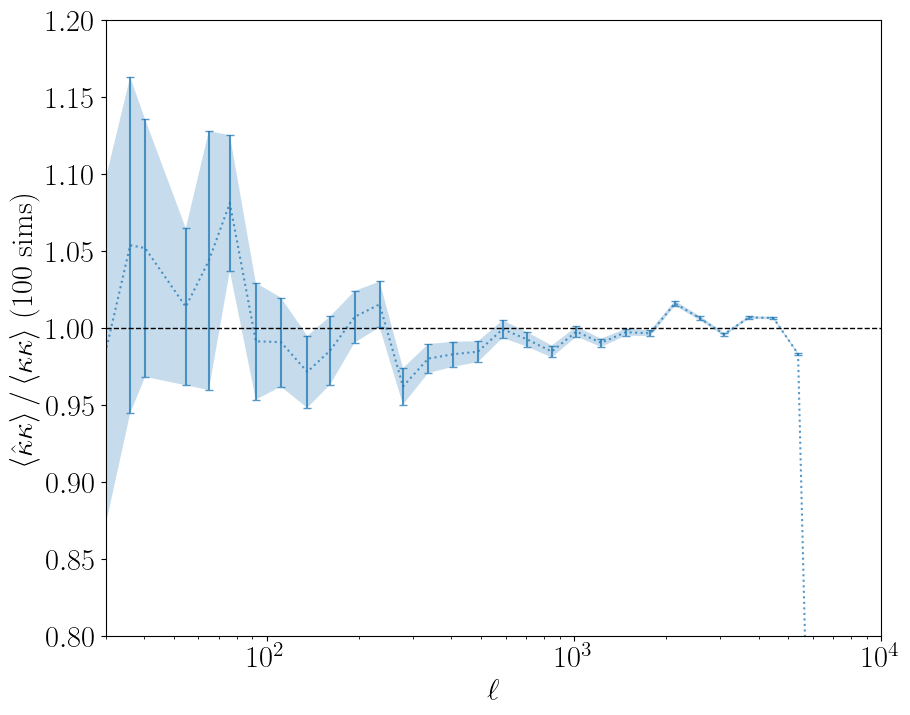

In [40]:
fig,ax = plt.subplots(nrows=1, figsize=(10,8))

lCen, Cl, sCl = combine_Cl(np.array(ps_data[ck]))

kk_true = np.array([p2d_cmblens.fPinterp(l) for l in lCen])

Cl = Cl/kk_true
sCl = sCl/kk_true

Ipos = np.where(Cl>=1e-30)
ax.errorbar(lCen[Ipos], (Cl[Ipos]), yerr=sCl[Ipos], alpha=.75, 
            fmt=':', capsize=3, capthick=1)


tmp_data = {
        'x': lCen[Ipos],
        'y1': [y - e for y, e in zip((Cl[Ipos]), sCl[Ipos])],
        'y2': [y + e for y, e in zip((Cl[Ipos]), sCl[Ipos])]}
ax.fill_between(**tmp_data,  alpha=.25)
    
plt.xscale('log')
plt.xlabel(r'$\ell$')
# plt.yscale('log')

plt.ylabel(r'$\left<\hat\kappa \kappa\right>/\left<\kappa \kappa\right>$ (100 sims)')
plt.ylim(0.8,1.2)
plt.xlim(30,1e4)

plt.axhline(1, linewidth=1, linestyle="--", color="black")
plt.savefig('figures/khatk_over_kk_800x800_20x20.pdf')